In [1]:
%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
# pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列

def set_ch():
    from pylab import mpl
    #中文字体问题已经解决，记录在evernote中
    #mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
set_ch()
from datetime import datetime,timedelta
import matplotlib
matplotlib.style.use('ggplot')
import sys
import json
import seaborn as sns

In [2]:
# import data
df_up = pd.read_csv('data/index_up.csv')
df_middle = pd.read_csv('data/index_mid.csv')
df_down = pd.read_csv('data/index_down.csv')

df_all = pd.concat([df_down, df_middle, df_up], axis=0).reset_index().drop(['index'], axis=1)
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_sd,ins_m,auc_sub_avg,auc_sub_sd,ins_min,ins_four_1,ins_four_2,ins_four_3,ins_max,ins_summit_min,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,6.432251,2.033708,97.156679,8.085544,0,0.0,0.0,0.0,43,0,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,3.940904,1.000000,98.138889,9.697912,0,0.0,0.0,0.0,25,0,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down
2,64005,A1,2017-07-01 00:00:00,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,4.442761,0.920290,99.359903,3.725814,0,0.0,0.0,0.0,32,0,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down


## 过滤学校

In [3]:
# filtering other schools
df_schools = pd.read_excel('data/school.xlsx')
top_schl_id = [np.int(df_schools.top_schl_id[i]) for i in range(len(df_schools))]
df_schools['top_schl_id'] = top_schl_id
df_schools = df_schools.sort_values(by=u'付费学生数',ascending=False).iloc[:41].sort_values(by=u'续费率',ascending=False)

school_li = [True if df_all.top_schl_id[i] in df_schools.top_schl_id.values else False for i in range(len(df_all))]
df_all = df_all[school_li]
df_all = df_all.reset_index().drop(['index'], axis=1)

In [4]:
# filtering the meaningless columns
df_all = df_all.drop(['ins_sd', 'ins_four_1', 'ins_four_2','ins_four_3','ins_min', 'ins_summit_min'],axis=1)

## 生成特征

#### ①时间相关特征

In [5]:
df_all['usr_visa_strt_tm'] = pd.to_datetime(df_all.usr_visa_strt_tm)
df_all['usr_visa_end_tm'] = pd.to_datetime(df_all.usr_visa_end_tm)

# 时间间隔
delta = (df_all.usr_visa_end_tm - df_all.usr_visa_strt_tm)
delta_days = [delta[i].days for i in range(len(delta))]
df_all['delta_days'] = delta_days

# year
df_all['year'] = [df_all.usr_visa_end_tm[i].year for i in range(len(df_all))]

# 时间间隔label
delta_lable = []
for i in range(len(df_all)):
    if df_all.delta_days[i] < 40:
        delta_lable.append('1m')
    elif (40<=df_all.delta_days[i]) & (df_all.delta_days[i] < 100):
        delta_lable.append('3m')
    elif (100<=df_all.delta_days[i]) & (df_all.delta_days[i] < 200):
        delta_lable.append('6m')
    elif (200<=df_all.delta_days[i]) & (df_all.delta_days[i] < 400):
        delta_lable.append('1y')
    elif (400<=df_all.delta_days[i]) & (df_all.delta_days[i] < 800):
        delta_lable.append('2y')
    elif (800<=df_all.delta_days[i]) & (df_all.delta_days[i] < 1200):
        delta_lable.append('3y')
    else:
        delta_lable.append('3ypl')

df_all['delta_lable'] = delta_lable

In [6]:
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable
0,64005,A,2016-06-19,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,183,2016,6m
1,64005,A1,2016-12-24,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,1.000000,98.138889,9.697912,25,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down,182,2017,6m
2,64005,A1,2017-07-01,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,0.920290,99.359903,3.725814,32,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down,155,2017,6m


#### ②区域相关特征

In [7]:
df_schools['province'] = ['beijin','taizhou','taizhou','beijin','ningbo','dalian','changzhou','xian','changchun','wuhan',
                          'wuxi','beijin','beijin','shanghai','beijin','jiamusi','shanghai','beijin','hangzhou','zhuhai',
                          'yangzhou','shanghai','shanghai','wenzhou','shanghai','nantong','chongqing','yantai','wenzhou','chongqing',
                          'shanghai','shenzheng','huzhou','beijin','shanghai','shanghai','beijin','changsha','linfen','wuhan',
                          'jixi']
df_schools['level'] = ['1st','2nd','2nd','1st','new1','new1','2nd','new1','2nd','new1',
                       '2nd','1st','1st','1st','1st','4th','1st','1st','new1','2nd',
                       '3rd','1st','1st','2nd','1st','2nd','new1','2nd','2nd','new1',
                       '1st','1st','3rd','1st','1st','1st','1st','new1','4th','new1',
                       '5th']

df_all = pd.merge(df_all, df_schools[['top_schl_id','province','level']],on='top_schl_id',how='left')

In [8]:
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,province,level
0,64005,A,2016-06-19,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st
1,64005,A1,2016-12-24,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,1.000000,98.138889,9.697912,25,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down,182,2017,6m,linfen,4th
2,64005,A1,2017-07-01,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,0.920290,99.359903,3.725814,32,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down,155,2017,6m,beijin,1st


In [9]:
# finding the the columns including NAN
def findingNAN(df):
    colNaN = [col for col in df.columns.values if df[col].isnull().any()==True]
    return colNaN

# filling the NAN upon the suggestion of sara
def filling(df, col_li):
    if 'pub_avg' in col_li:
        df['pub_avg'] = df.pub_avg.fillna(df.pub_avg.mean(skipna=True))
        col_li.remove('pub_avg')
    else:
        pass
    for col in col_li:
        df[col] = df[col].fillna(0)
    return df

In [10]:
df_all = filling(df_all, findingNAN(df_all))

In [11]:
df_all.head(3)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,province,level
0,64005,A,2016-06-19,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.562500,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st
1,64005,A1,2016-12-24,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.000000,1032,0.538399,145.235432,128.694444,1.000000,98.138889,9.697912,25,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down,182,2017,6m,linfen,4th
2,64005,A1,2017-07-01,2017-12-03 22:06:52,2092.0,2017-07-01 21:03:18,77.960718,11,138,1.770122,12.545455,868,0.642373,51.065638,80.702899,0.920290,99.359903,3.725814,32,56.00,72.5,102.50,387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,8,4,87,20,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,54,24,570,102,48,0,38.0,255.0,48.0,287.0,52.0,326.0,2.766655,1.802080,602,32,1.44186,0.776597,1.0,434410.0,down,155,2017,6m,beijin,1st


In [12]:
df_all.to_csv('data/all.csv')

------------------

In [13]:
# import data
df_all = pd.read_csv('data/all.csv').drop(['Unnamed: 0'], axis=1)

### 1.所有特征

In [14]:
df_all.head(2)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,province,level
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.5625,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.00,102.0,201.00,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st
1,64005,A1,2016-12-24 00:00:00,2017-06-24 23:59:59,1626.0,2016-12-24 20:21:05,91.499994,18,180,1.967213,10.0000,1032,0.538399,145.235432,128.694444,1.000000,98.138889,9.697912,25,67.75,101.0,156.25,1427,0,0,0,0,0,0,0,0,4,0,0,0,0,0,10,3,0,0,0,73,63,27,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,60,9,0,0,0,424,356,163,0,0,18.0,95.0,120.0,693.0,42.0,244.0,2.796135,1.737008,501,28,2.05988,0.977961,1.0,436223.0,down,182,2017,6m,linfen,4th


In [15]:
# standardization & normalization
from sklearn import preprocessing
def processing(df, exp):
    X = df.values
    if exp == 'standardization':
        scaler = preprocessing.StandardScaler().fit(X)
        X_ = scaler.transform(X)
    elif exp == 'normalization':
        scaler = preprocessing.MinMaxScaler().fit(X)
        X_ = scaler.transform(X)
    else:
        raise Exception("Unknown type")
    df_ = pd.DataFrame(X_)
    df_.columns = df.columns.values
    return df_

In [16]:
df_X = df_all.iloc[:, 6:-8]
df_X = pd.concat([df_X,
           pd.get_dummies(df_all.visa_typ_cd),
           pd.get_dummies(df_all.year),
           pd.get_dummies(df_all.delta_lable),
           pd.get_dummies(df_all.level),
           pd.get_dummies(df_all.top_schl_id)],
           axis=1)

In [17]:
# 标准化
df_Xstd = processing(df_X, 'standardization')

In [18]:
X_std = df_Xstd.values
y = df_all.y

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report,f1_score,auc,roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import  GridSearchCV

/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
# logistic regression
def LR(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    lr = LogisticRegression(penalty = 'l1')
    print ('training...')
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    print ('predict finished')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y_test,Y_pred)
    F1 = f1_score(Y_test, Y_pred)
    # auc_score = auc(Y_test, Y_pred)
    # roc_auc = roc_auc_score(Y_test, Y_pred)

    return (Y_pred, lr, cnf_matrix, F1)

In [44]:
y_pred_std, lr_std, cnf_matrix_std, F1_std= LR(X_std,y)

training...
predict finished


In [22]:
coef_li = []
F1_std_li = []
intercept_li = []
for i in np.arange(1,11):
    y_pred_std, lr_std, cnf_matrix_std, F1_std= LR(X_std,y)
    coef_li.append(lr_std.coef_)
    F1_std_li.append(F1_std)
    intercept_li.append(lr_std.intercept_)

training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished
training...
predict finished


In [23]:
np.mean(F1_std_li)

0.96296493929027382

,par_days,430552.0,432643.0,1st,432710.0,1m,2015,sc_ex,432791.0,434200.0,437282.0,2014,434266.0,409.0,n_pkg,430627.0,sub_ins_sd,sub_avg_a,2016,435620.0,new1,437367.0,auc_sub_sd,20point_ex,432610.0,ins_summit_four_2,5point_sub,437357.0,notscWd_ex,19point_sub,18point_sub,10point_ex,17point_ex,21point_sub,2013,9point_sub,437414.0,437317.0,11point_ex,7point_sub,15point_ex,13point_ex,6point_sub,437353.0,22point_sub,435300.0,0point_sub,12point_sub,sub_tol,A1,16point_sub,2point_ex,3point_sub,13point_sub,22point_ex,17point_sub,D2,D1,12point_ex,7point_ex,3m,ex_tol,A2,8point_ex,14point_ex,6point_ex,notscWd_sub,14point_sub,23point_sub,435467.0,ex_subrate,D3,A3,1point_ex,2point_sub,3point_ex,21point_ex,3rd,A,4th,6m,1point_sub,16point_ex,438276.0,8point_sub,4point_sub,4point_ex,11point_sub,18point_ex,23point_ex,9point_ex,435590.0,430558.0,432590.0,438445.0,sc_sub,sub_ins_m,ins_summit_four_3,notscWe_sub,19point_ex,20point_sub,n_pra_ex_sd,notscWe_ex,10point_sub,432699.0,B,0point_ex,435391.0,auc_sub_avg,15point_sub,432468.0,430564.0,438456.0,436070.0,440467.0,434410.0,436223.0,ins_m,436224.0,2018,n_pra_ex_avg,1y,5point_ex,439176.0,ins_summit_four_1,pub_avg,3y,ins_summit_max,3ypl,pub_sd,sub_avg,C,ins_max,432715.0,2017,2y,439175.0,439174.0,439177.0,431016.0,n_ex,actual_day,2nd,432466.0
weight,-1.178076,-1.13988,-0.597216,-0.488236,-0.409875,-0.310562,-0.305362,-0.30046,-0.261817,-0.252234,-0.251019,-0.248589,-0.189747,-0.178599,-0.165743,-0.16514,-0.155533,-0.146629,-0.123974,-0.101979,-0.099968,-0.098878,-0.097329,-0.094631,-0.09383,-0.089201,-0.08874,-0.080762,-0.080312,-0.08008,-0.077779,-0.066645,-0.06422,-0.062807,-0.057472,-0.051274,-0.046272,-0.044254,-0.043268,-0.043163,-0.041934,-0.041555,-0.040885,-0.037322,-0.035551,-0.034262,-0.029994,-0.029024,-0.028661,-0.027011,-0.024575,-0.02333,-0.02266,-0.021629,-0.019149,-0.018474,-0.016806,-0.016328,-0.01623,-0.014572,-0.013334,-0.011487,-0.010798,-0.00995,-0.008707,-0.008369,-0.008212,-0.007354,-0.006048,-0.005164,-0.005142,-0.002183,-0.001536,-0.001238,-0.001218,-0.001011,-0.000022,0.0,0.0,0.0,0.0,0.001822,0.002205,0.003917,0.004957,0.006621,0.007432,0.007505,0.008424,0.008768,0.008964,0.010703,0.016884,0.017656,0.020798,0.021845,0.022405,0.023355,0.025666,0.025748,0.031092,0.031705,0.032455,0.032774,0.03504,0.037582,0.039153,0.047614,0.052515,0.052596,0.06415,0.066092,0.069307,0.071229,0.072567,0.075311,0.077173,0.083182,0.088172,0.088813,0.093062,0.095522,0.100829,0.101839,0.105662,0.106059,0.10672,0.110372,0.122286,0.124389,0.196242,0.257443,0.266615,0.280479,0.302993,0.314029,0.334659,0.39214,0.467827,0.738029,0.802103,0.809987,0.906083,2.798572


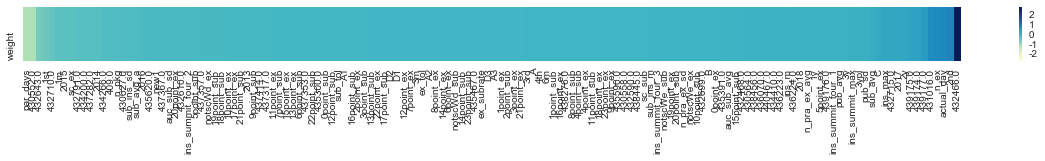

In [25]:
coef_avg = (coef_li[0] + coef_li[1] + coef_li[2] + coef_li[3] + coef_li[4] + 
            coef_li[5] + coef_li[6] + coef_li[7] + coef_li[8] + coef_li[9])/10
intercept_avg = np.array(intercept_li).cumsum()[-1] / 10
df_weight_std = pd.DataFrame(coef_avg.T)
df_weight_std.index = df_Xstd.columns.values
df_weight_std.columns = ['weight']

# plot weight
plt.rc('figure', figsize=(21, 1))
sns.heatmap(df_weight_std.sort_values(by=['weight']).T,cmap="YlGnBu")
df_weight_std.sort_values(by=['weight']).T

In [26]:
# calculate probability
std_ = np.sum(X_std * coef_avg, axis=1) + intercept_avg
df_Xstd['wTx'] = std_
df_Xstd['probability'] = 1.0 / (1.0  + np.exp(-std_))

In [27]:
len(df_all[df_all.top_schl_id == 432643])

22153

In [28]:
# lable the student
lable_li_std = []
for i in range(len(df_Xstd)):
    if df_Xstd.probability[i] < 0.1:
        lable_li_std.append('0')
    elif df_Xstd.probability[i] > 0.9:
        lable_li_std.append('1')
    else:
        lable_li_std.append('0.5')
        
df_Xstd['lable'] = lable_li_std
df_X['lable'] = lable_li_std

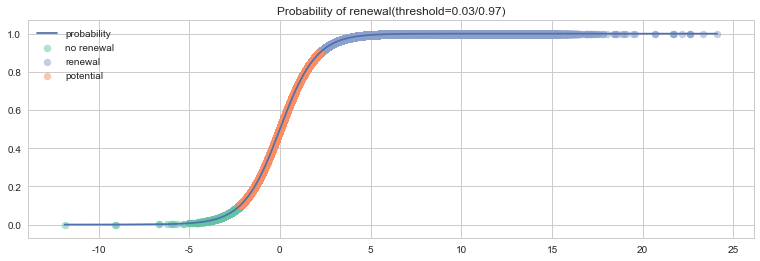

In [29]:
# standardization
df_sorted_std = DataFrame()
df_sorted_std['wTx'] = np.sort(np.sum(X_std * lr_std.coef_, axis=1) + lr_std.intercept_)
df_sorted_std['probability'] = 1.0 / (1.0  + np.exp(-(df_sorted_std.wTx)))

sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 4))
plt.plot(df_sorted_std.wTx, df_sorted_std.probability)
plt.scatter(df_sorted_std[df_sorted_std.probability<0.1].wTx, df_sorted_std[df_sorted_std.probability<0.1].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[0], label='no renewal')
plt.scatter(df_sorted_std[df_sorted_std.probability>0.9].wTx, df_sorted_std[df_sorted_std.probability>0.9].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[2], label='renewal')
plt.scatter(df_sorted_std[(df_sorted_std.probability>0.1)&(df_sorted_std.probability<0.9)].wTx, 
            df_sorted_std[(df_sorted_std.probability>0.1)&(df_sorted_std.probability<0.9)].probability, 
            marker='o',alpha=0.5, color=sns.color_palette("Set2", 10)[1], label='potential')
plt.title("Probability of renewal(threshold=0.03/0.97)")
plt.legend()

In [30]:
print ('no renewal: %s' % len(df_Xstd[df_Xstd.lable == '0']))
print ('renewal: %s' % len(df_Xstd[df_Xstd.lable == '1']))
print ('potential: %s' % len(df_Xstd[df_Xstd.lable == '0.5']))

no renewal: 6728
renewal: 314997
potential: 108246


In [31]:
[len(df_Xstd[df_Xstd.lable == '0'])/len(df_all[df_all.y == 0]),
len(df_Xstd[df_Xstd.lable == '1'])/len(df_all[df_all.y == 1])]

[0.1328489060895664, 0.8304101738078228]

In [32]:
len(df_all.top_schl_id.value_counts())

40

##### 一些统计结果

①一天的时间段内的提交数 和 做题数

In [33]:
df_Xstd.head(2)

,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,A,A1,A2,A3,B,C,D1,D2,D3,2013,2014,2015,2016,2017,2018,1m,1y,2y,3m,3y,3ypl,6m,1st,2nd,3rd,4th,new1,409.0,430552.0,430558.0,430564.0,430627.0,431016.0,432466.0,432468.0,432590.0,432610.0,432643.0,432699.0,432710.0,432715.0,432791.0,434200.0,434266.0,434410.0,435300.0,435391.0,435467.0,435590.0,435620.0,436070.0,436223.0,436224.0,437282.0,437317.0,437353.0,437357.0,437367.0,437414.0,438276.0,438445.0,438456.0,439174.0,439175.0,439176.0,439177.0,440467.0,wTx,probability,lable
0,-0.032994,-0.395991,-0.644934,-0.55590,-0.817637,-0.562815,-0.362222,-0.786112,-0.382418,0.929265,0.674576,-1.010253,0.658202,-0.125796,0.203494,0.071062,-0.971771,-0.075599,-0.052983,-0.05563,-0.046054,-0.048611,-0.063624,-0.187999,-0.324657,-0.403517,-0.359850,-0.430746,-0.499592,-0.441611,-0.498875,-0.446977,-0.467182,-0.516681,-0.581866,-0.648646,-0.607031,0.674437,-0.079762,-0.285579,-0.188832,-0.060146,-0.044166,-0.052325,-0.038121,-0.03656,-0.023851,-0.127496,-0.309272,-0.379867,-0.328007,-0.4386,-0.491619,-0.443492,-0.491241,-0.451139,-0.46071,-0.517918,-0.574976,-0.637423,-0.615394,0.762624,-0.075365,-0.223572,-0.183228,-0.453935,-0.400993,-0.731110,-0.669685,-0.355624,-0.274958,1.580921,0.988677,-0.589287,-0.350931,-0.142578,-0.040778,1.279940,-0.054814,-0.149525,-0.024551,-0.979718,-0.12426,-0.071829,-0.304659,-0.021572,-0.059009,-0.171944,-0.286249,2.327568,-1.016616,-0.54348,-0.318265,-0.285392,-0.193144,-0.239954,-0.035131,-0.01276,0.59135,1.115369,-0.924525,-0.135348,-0.141106,-0.243613,-0.174041,-0.498742,-0.070741,-0.123067,-0.058471,-0.305497,-0.728863,-0.090147,12.916126,-0.064802,-0.233068,-0.120053,-0.145075,-0.175144,-0.074685,-0.174996,-0.098493,-0.201771,-0.051989,-0.083879,-0.043256,-0.047845,-0.07248,-0.050898,-0.119873,-0.072723,-0.095599,-0.055493,-0.063449,-0.073383,-0.052592,-0.049146,-0.072965,-0.052414,-0.061745,-0.088707,-0.056909,-0.046558,-0.064074,-0.025664,3.175632,0.959907,1
1,-0.041684,-0.305489,-0.259459,-0.28454,-0.008862,-0.169347,-0.889352,-0.866513,-0.517958,0.118387,0.766177,-0.841056,-0.068718,0.827377,0.193444,-0.089558,-0.980637,-0.075599,-0.052983,-0.05563,-0.046054,-0.048611,-0.063624,-0.187999,-0.324657,-0.159447,-0.464982,-0.430746,-0.499592,-0.441611,-0.498875,-0.025150,-0.340347,-0.516681,-0.581866,-0.648646,0.937576,0.697239,0.194314,-0.406529,-0.188832,-0.060146,-0.044166,-0.052325,-0.038121,-0.03656,-0.023851,-0.127496,-0.309272,-0.155416,-0.442740,-0.4386,-0.491619,-0.443492,-0.491241,0.046883,-0.38821,-0.517918,-0.574976,-0.637423,1.085120,0.722857,0.275671,-0.388289,-0.183228,-0.709579,-0.690476,0.482687,0.524549,-0.355624,-0.282061,0.600140,0.608863,-0.469770,-0.262717,0.900098,0.282025,-0.781286,18.243586,-0.149525,-0.024551,-0.979718,-0.12426,-0.071829,-0.304659,-0.021572,-0.059009,-0.171944,-0.286249,-0.429633,0.983656,-0.54348,-0.318265,-0.285392,-0.193144,-0.239954,-0.035131,-0.01276,0.59135,-0.896564,-0.924525,-0.135348,7.086862,-0.243613,-0.174041,-0.498742,-0.070741,-0.123067,-0.058471,-0.305497,-0.728863,-0.090147,-0.077423,-0.064802,-0.233068,-0.120053,-0.145075,-0.175144,-0.074685,-0.174996,-0.098493,-0.201771,-0.051989,-0.083879,-0.043256,-0.047845,-0.07248,-0.050898,

In [34]:
# 以年份来划分记录
df_13 = df_X[df_X[2013] == 1]
df_14 = df_X[df_X[2014] == 1]
df_15 = df_X[df_X[2015] == 1]
df_16 = df_X[df_X[2016] == 1]
df_17 = df_X[df_X[2017] == 1]
df_18 = df_X[df_X[2018] == 1]

print ("2013 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_13), len(df_13[df_13.lable=='1']), len(df_13[df_13.lable=='0'])))
print ("2014 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_14), len(df_14[df_14.lable=='1']), len(df_14[df_14.lable=='0'])))
print ("2015 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_15), len(df_15[df_15.lable=='1']), len(df_15[df_15.lable=='0'])))
print ("2016 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_16), len(df_16[df_16.lable=='1']), len(df_16[df_16.lable=='0'])))
print ("2017 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_17), len(df_17[df_17.lable=='1']), len(df_17[df_17.lable=='0'])))
print ("2018 record number:%s, renewal number:%s, not renewl:%s" % 
       (len(df_18), len(df_18[df_18.lable=='1']), len(df_18[df_18.lable=='0'])))

2013 record number:1492, renewal number:761, not renewl:114
2014 record number:12347, renewal number:4504, not renewl:3098
2015 record number:32563, renewal number:19884, not renewl:3091
2016 record number:66999, renewal number:42803, not renewl:377
2017 record number:218528, renewal number:170433, not renewl:28
2018 record number:98042, renewal number:76612, not renewl:20


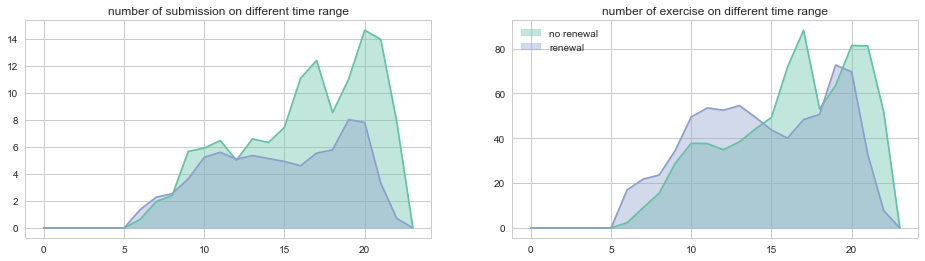

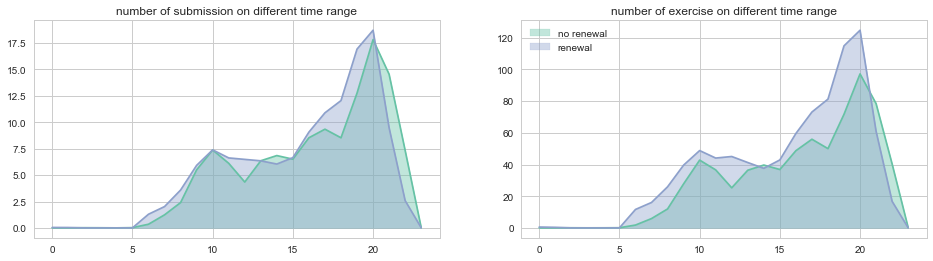

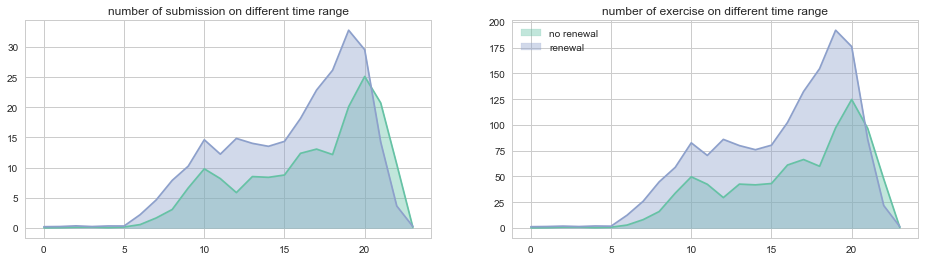

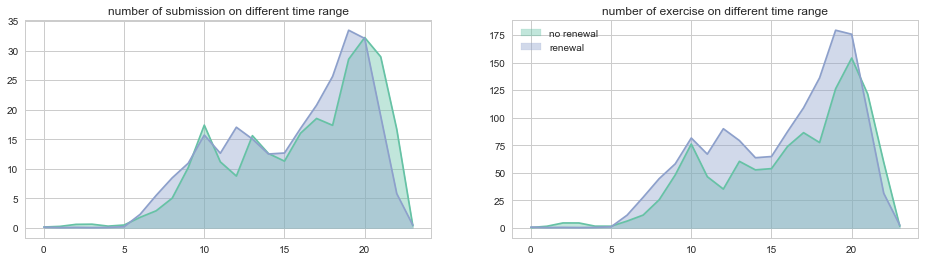

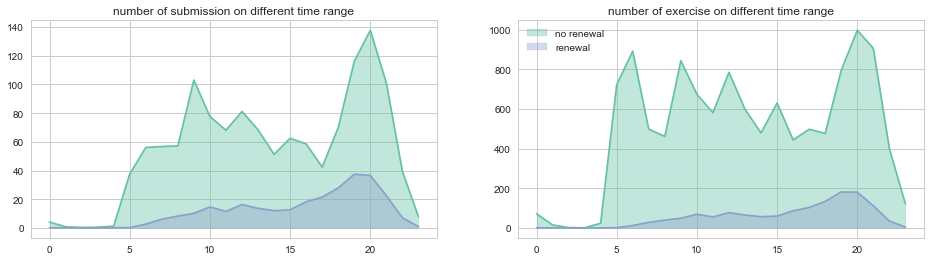

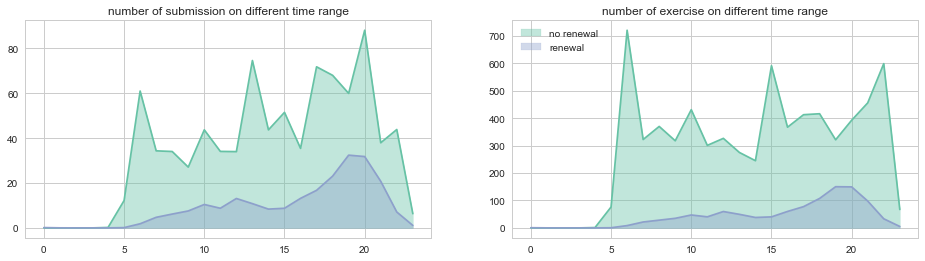

In [35]:
# 不同年份在一天的时间段内提交数和做题数
for i in ['df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18']:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    # number of submission
    eval('ax1.plot(np.arange(0,24),'+ i + '[' + i + '.lable == "0"].iloc[:,17:41].mean(axis=0),color=sns.color_palette("Set2", 10)[0])')
    eval('ax1.fill_between(np.arange(0,24),'+ i + '[' + i + '.lable == "0"].iloc[:,17:41].mean(axis=0),0,color=sns.color_palette("Set2", 10)[0], alpha=0.4, label="no renewal")')
    eval('ax1.plot(np.arange(0,24),'+ i + '[' + i + '.lable == "1"].iloc[:,17:41].mean(axis=0),color=sns.color_palette("Set2", 10)[2])')
    eval('ax1.fill_between(np.arange(0,24),'+ i + '[' + i + '.lable == "1"].iloc[:,17:41].mean(axis=0),0,color=sns.color_palette("Set2", 10)[2], alpha=0.4, label="renewal")')
    eval('ax1.set_title("number of submission on different time range")')

    # number of exercise
    eval('ax2.plot(np.arange(0,24),'+ i + '[' + i + '.lable == "0"].iloc[:,41:65].mean(axis=0),color=sns.color_palette("Set2", 10)[0])')
    eval('ax2.fill_between(np.arange(0,24),'+ i + '[' + i + '.lable == "0"].iloc[:,41:65].mean(axis=0),0,color=sns.color_palette("Set2", 10)[0], alpha=0.4, label="no renewal")')
    eval('ax2.plot(np.arange(0,24),'+ i + '[' + i + '.lable == "1"].iloc[:,41:65].mean(axis=0),color=sns.color_palette("Set2", 10)[2])')
    eval('ax2.fill_between(np.arange(0,24),'+ i + '[' + i + '.lable == "1"].iloc[:,41:65].mean(axis=0),0,color=sns.color_palette("Set2", 10)[2], alpha=0.4, label="renewal")')
    eval('ax2.set_title("number of exercise on different time range")')
    plt.legend(loc='upper left')    

②工作日、周末、寒暑假的使用情况

In [36]:
df_all['lable'] = df_X.lable

In [37]:
# 生成新表
renewl_dic = {'"renewal"':'"1"', '"not renewal"':'"0"'}
sub_dic = {'sub':'"sub"', 'ex':'"ex"'}
period_dic = {'notscWd':'"workDay"', 'notscWe':'"weekDay"', 'sc':'"vacation"'}
year_li = ["2013", "2014", "2015", "2016", "2017", "2018"]

all_li = []
for year in year_li:
    for (period,p_label) in period_dic.items():
        for (sub,sub_label) in sub_dic.items():
            for (key,val) in renewl_dic.items():
                all_li.append(eval("[df_all[(df_all.lable ==" + val + ")&(df_all.year ==" +  year + ")]." + period + "_" + sub + ".mean(axis=0)," + year +"," + key + "," + p_label + "," + sub_label + "]"))

df_period = pd.DataFrame(all_li)
df_period.columns = ['number', 'year', 'renewal/not', 'period', 'sub/ex']

In [38]:
df_period

,number,year,renewal/not,period,sub/ex
0,126.745614,2013,not renewal,vacation,sub
1,41.599212,2013,renewal,vacation,sub
2,779.192982,2013,not renewal,vacation,ex
3,371.207622,2013,renewal,vacation,ex
4,0.245614,2013,not renewal,weekDay,sub
5,17.191853,2013,renewal,weekDay,sub
6,2.605263,2013,not renewal,weekDay,ex
7,160.139290,2013,renewal,weekDay,ex
8,1.403509,2013,not renewal,workDay,sub
9,20.550591,2013,renewal,workDay,sub


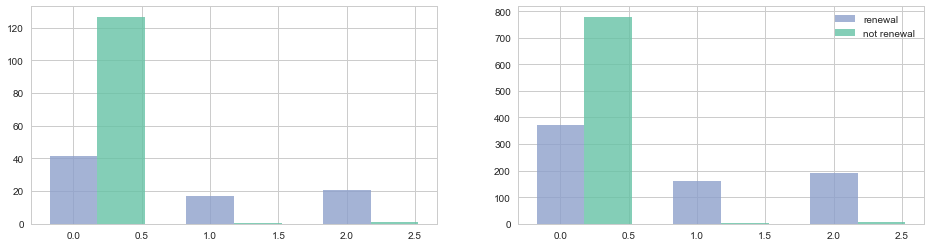

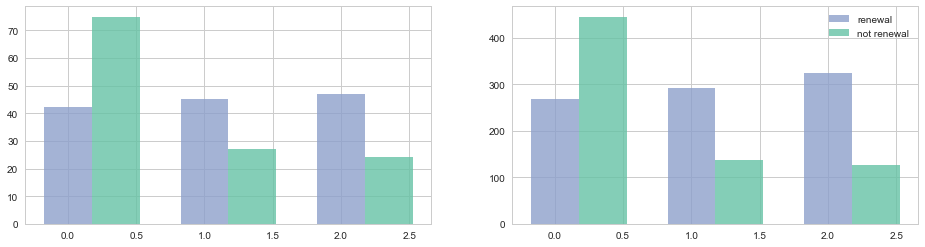

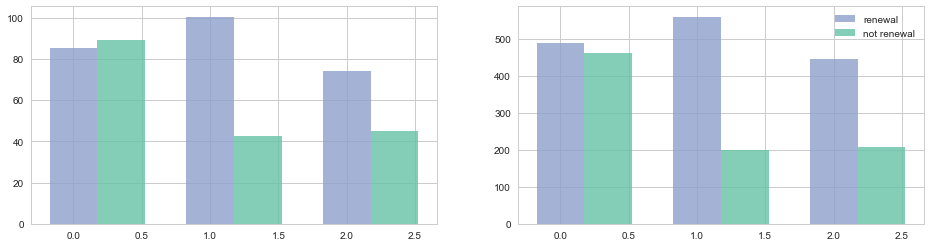

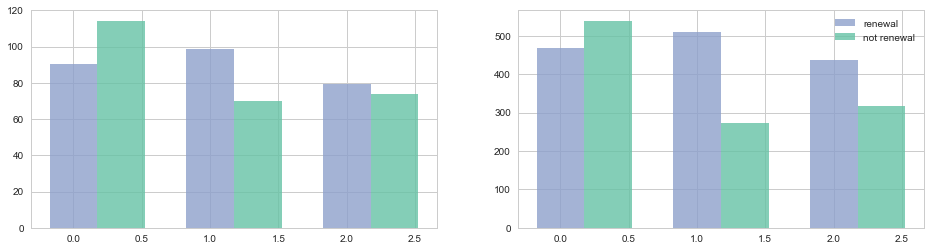

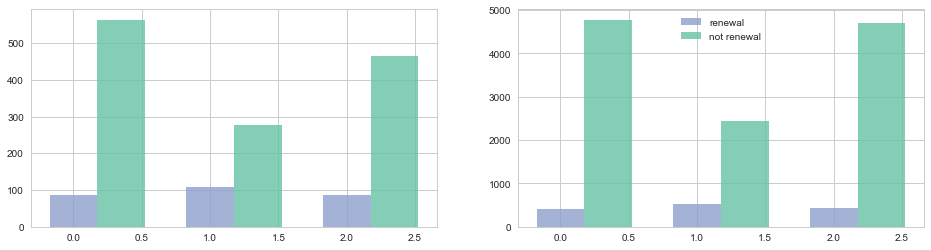

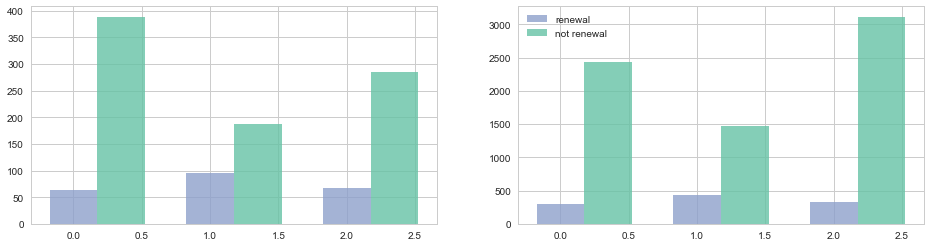

In [39]:
# 生成图
for year in [2013, 2014, 2015, 2016, 2017, 2018]:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    # submission
    ax1.bar(np.arange(0,3), df_period[(df_period['renewal/not'] == 'renewal') & 
                                  (df_period['sub/ex'] == 'sub') &
                                  (df_period.year == year)].number, 
                                  0.35,color=sns.color_palette("Set2", 10)[2],label='renewal',alpha=0.8)
    ax1.bar(np.arange(0,3)+0.35, df_period[(df_period['renewal/not'] == 'not renewal') & 
                                  (df_period['sub/ex'] == 'sub') &
                                  (df_period.year == year)].number, 
                                  0.35,color=sns.color_palette("Set2", 10)[0],label='not renewal', alpha=0.8)
    # exercise
    ax2.bar(np.arange(0,3), df_period[(df_period['renewal/not'] == 'renewal') & 
                                  (df_period['sub/ex'] == 'ex') &
                                  (df_period.year == year)].number, 
                                  0.35,color=sns.color_palette("Set2", 10)[2],label='renewal', alpha=0.8)
    ax2.bar(np.arange(0,3)+0.35, df_period[(df_period['renewal/not'] == 'not renewal') & 
                                  (df_period['sub/ex'] == 'ex') &
                                  (df_period.year == year)].number, 
                                  0.35,color=sns.color_palette("Set2", 10)[0],label='not renewal', alpha=0.8)
    plt.legend()

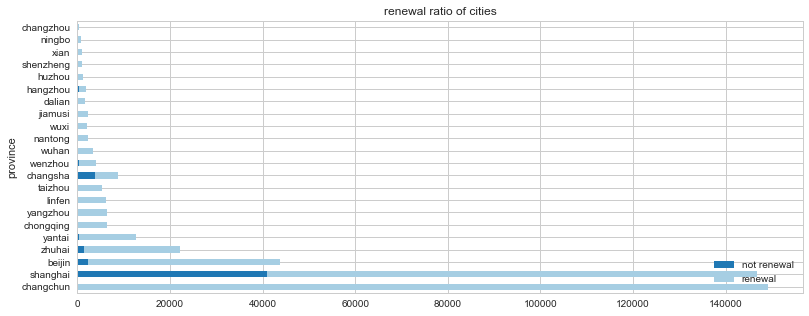

In [45]:
df_city_renewal = DataFrame(df_all.groupby(['province','y']).size()).unstack()[0]
df_city_renewal.columns = ['not renewal','renewal']
df_city_renewal = df_city_renewal.sort_values(by=['renewal'], ascending=False)

sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 5))
df_city_renewal.plot(kind='barh',stacked=True,legend=True,color=[sns.color_palette("Paired")[1],sns.color_palette("Paired")[0]])
plt.legend(loc='lower right')
plt.title('renewal ratio of cities')

In [47]:
df_all.head(1)

,stu_id,visa_typ_cd,usr_visa_strt_tm,usr_visa_end_tm,group,min_time,par_days,actual_day,sub_tol,sub_avg,sub_avg_a,ex_tol,ex_subrate,sub_ins_sd,sub_ins_m,ins_m,auc_sub_avg,auc_sub_sd,ins_max,ins_summit_four_1,ins_summit_four_2,ins_summit_four_3,ins_summit_max,0point_sub,1point_sub,2point_sub,3point_sub,4point_sub,5point_sub,6point_sub,7point_sub,8point_sub,9point_sub,10point_sub,11point_sub,12point_sub,13point_sub,14point_sub,15point_sub,16point_sub,17point_sub,18point_sub,19point_sub,20point_sub,21point_sub,22point_sub,23point_sub,0point_ex,1point_ex,2point_ex,3point_ex,4point_ex,5point_ex,6point_ex,7point_ex,8point_ex,9point_ex,10point_ex,11point_ex,12point_ex,13point_ex,14point_ex,15point_ex,16point_ex,17point_ex,18point_ex,19point_ex,20point_ex,21point_ex,22point_ex,23point_ex,notscWe_sub,notscWe_ex,notscWd_sub,notscWd_ex,sc_sub,sc_ex,pub_avg,pub_sd,n_ex,n_pkg,n_pra_ex_avg,n_pra_ex_sd,y,top_schl_id,school,delta_days,year,delta_lable,province,level,lable
0,64005,A,2016-06-19 00:00:00,2016-12-19 23:59:59,1625.0,2016-06-19 09:18:16,91.999994,16,89,0.967391,5.5625,509,0.647926,269.284575,179.550562,2.033708,97.156679,8.085544,43,25.0,102.0,201.0,1562,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,62,18,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,19,366,97,15,0,44.0,248.0,3.0,13.0,42.0,248.0,4.122255,2.054635,391,25,1.30179,0.604235,1.0,432590.0,down,183,2016,6m,beijin,1st,1


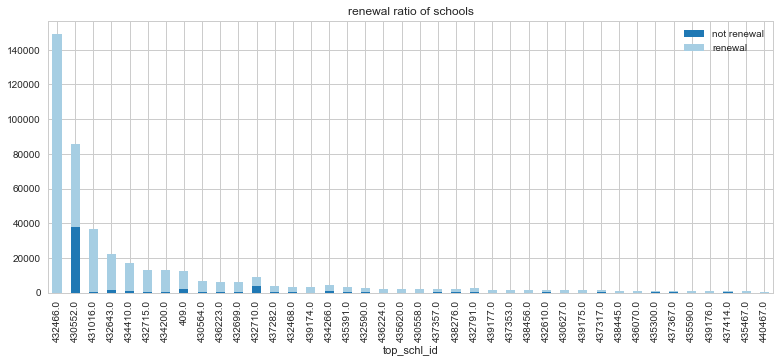

In [50]:
df_schl_renewal = DataFrame(df_all.groupby(['top_schl_id','y']).size()).unstack()[0]
df_schl_renewal.columns = ['not renewal','renewal']
df_schl_renewal = df_schl_renewal.sort_values(by=['renewal'], ascending=False)

sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 5))
df_schl_renewal.plot(kind='bar',stacked=True,legend=True,color=[sns.color_palette("Paired")[1],sns.color_palette("Paired")[0]])
plt.legend(loc='upper right')
plt.title('renewal ratio of schools')

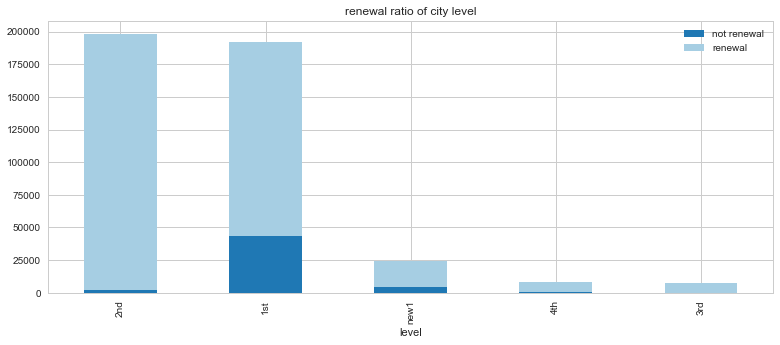

In [53]:
df_cityLevel_renewal = DataFrame(df_all.groupby(['level','y']).size()).unstack()[0]
df_cityLevel_renewal.columns = ['not renewal','renewal']
df_cityLevel_renewal = df_cityLevel_renewal.sort_values(by=['renewal'], ascending=False)


sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 5))
df_cityLevel_renewal.plot(kind='bar',stacked=True,legend=True,color=[sns.color_palette("Paired")[1],sns.color_palette("Paired")[0]])
plt.legend(loc='upper right')
plt.title('renewal ratio of city level')


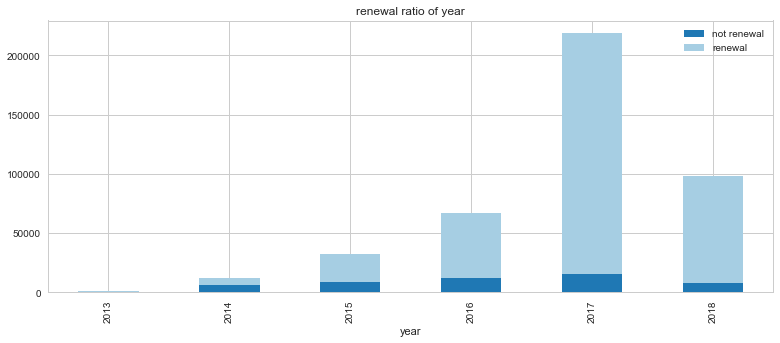

In [54]:
df_year_renewal = DataFrame(df_all.groupby(['year','y']).size()).unstack()[0]
df_year_renewal.columns = ['not renewal','renewal']
df_year_renewal = df_year_renewal.sort_index()

sns.set_style("whitegrid")
plt.rc('figure', figsize=(13, 5))
df_year_renewal.plot(kind='bar',stacked=True,legend=True,color=[sns.color_palette("Paired")[1],sns.color_palette("Paired")[0]])
plt.legend(loc='upper right')
plt.title('renewal ratio of year')


In [55]:
df_weight_test = df_weight_std.sort_values(by='weight')
df_test = DataFrame(df_weight_test.weight.abs() / df_weight_test.weight.abs().sum())
df_test['noabs'] = DataFrame(df_weight_test.weight / df_weight_test.weight.abs().sum())
df_test = df_test.sort_values(by='weight', ascending=False)
df_test = df_test.reset_index()

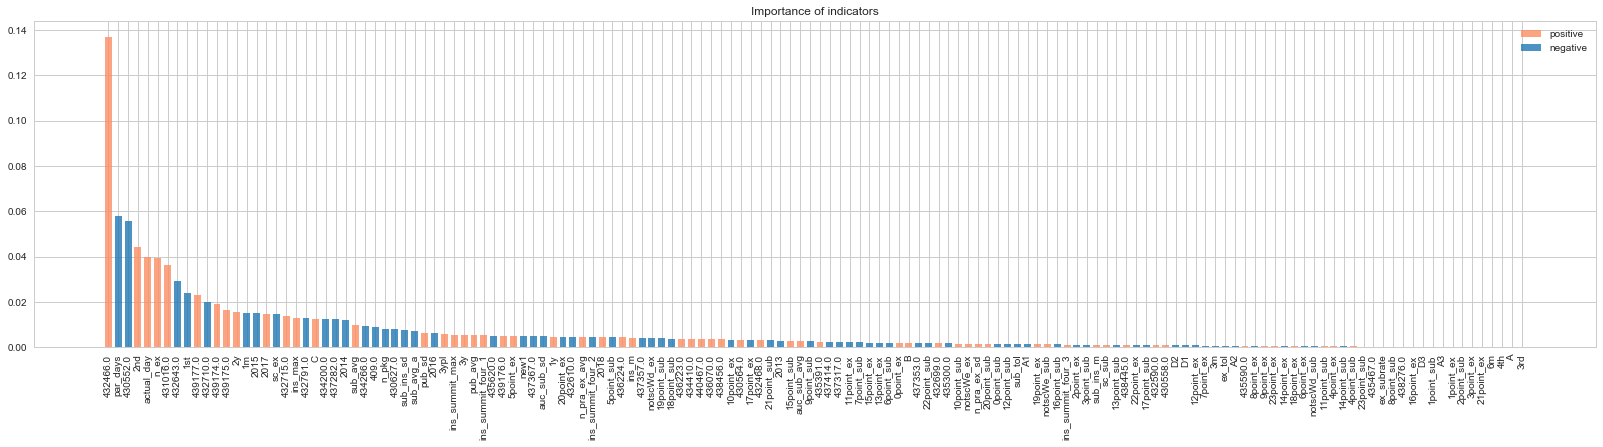

In [56]:
plt.rc('figure', figsize=(28, 6))
sns.set_style("whitegrid")
plt.bar(df_test[df_test.noabs >=0].index,
        df_test[df_test.noabs >=0].weight, 0.7,label='positive',alpha=0.8, color=sns.color_palette("Set2", 10)[1])
plt.xticks(np.arange(0,144), df_test['index'].values,rotation=90)
plt.bar(df_test[df_test.noabs <0].index,
        df_test[df_test.noabs <0].weight, 0.7,label='negative',alpha=0.8, color=sns.color_palette("Paired")[1])
plt.xticks(np.arange(0,144), df_test['index'].values,rotation=90)
plt.title("Importance of indicators")
plt.legend()